In [1]:
import pandas as pd
import numpy as np
import os
import sys
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt
import random
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# To play audio files
import IPython.display as ipd
from IPython.display import Audio

# PyTorch libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset

from pathlib import Path
import random
import glob

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import soundfile
from pydub import AudioSegment
from pydub.silence import detect_nonsilent

CREMA-D is a data set of 7,442 original clips from 91 actors. These clips were from 48 male and 43 female actors between the ages of 20 and 74 coming from a variety of races and ethnicities (African America, Asian, Caucasian, Hispanic, and Unspecified). Actors spoke from a selection of 12 sentences. The sentences were presented using one of six different emotions (Anger, Disgust, Fear, Happy, Neutral, and Sad) and four different emotion levels (Low, Medium, High, and Unspecified).

https://www.kaggle.com/datasets/ejlok1/cremad

In [2]:
#python3 'data/Crema-D/AudioWAV/'  'Crema' dataprocessing.py

In [3]:
Crema = "data/Crema-D/AudioWAV/"

'''
import kagglehub

# Download latest version
path = kagglehub.dataset_download("ejlok1/cremad")

print("Path to dataset files:", path)
'''

'\nimport kagglehub\n\n# Download latest version\npath = kagglehub.dataset_download("ejlok1/cremad")\n\nprint("Path to dataset files:", path)\n'

In [4]:
crema_directory_list = os.listdir(Crema)

file_emotion = []
file_path = []

for file in crema_directory_list:
    # storing file paths
    file_path.append(Crema + file)
    # storing file emotions
    part=file.split('_')
    if part[2] == 'SAD':
        file_emotion.append('sad')
    elif part[2] == 'ANG':
        file_emotion.append('angry')
    elif part[2] == 'DIS':
        file_emotion.append('disgust')
    elif part[2] == 'FEA':
        file_emotion.append('fear')
    elif part[2] == 'HAP':
        file_emotion.append('happy')
    elif part[2] == 'NEU':
        file_emotion.append('neutral')
    else:
        file_emotion.append('Unknown')
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Crema_df = pd.concat([emotion_df, path_df], axis=1)
print(Crema_df.Emotions.value_counts())

Emotions
disgust    1271
angry      1271
happy      1271
fear       1271
sad        1271
neutral    1087
Name: count, dtype: int64


In [5]:
Crema_df.head()

,Emotions,Path
0,disgust,data/Crema-D/AudioWAV/1011_TAI_DIS_XX.wav
1,angry,data/Crema-D/AudioWAV/1056_WSI_ANG_XX.wav
2,neutral,data/Crema-D/AudioWAV/1052_IEO_NEU_XX.wav
3,disgust,data/Crema-D/AudioWAV/1056_WSI_DIS_XX.wav
4,angry,data/Crema-D/AudioWAV/1035_IOM_ANG_XX.wav


In [6]:
LABEL_DICT = {0:'fear', 1:'neutral', 2:'happy',3:'angry', 4:'disgust', 5:'surprise',6:'sad'}
LABELS = list(LABEL_DICT.values())

reverse_label_dict = {v: k for k, v in LABEL_DICT.items()}
Crema_df['Emotions'] = Crema_df['Emotions'].map(reverse_label_dict)

In [7]:
Crema_df.head()

,Emotions,Path
0,4,data/Crema-D/AudioWAV/1011_TAI_DIS_XX.wav
1,3,data/Crema-D/AudioWAV/1056_WSI_ANG_XX.wav
2,1,data/Crema-D/AudioWAV/1052_IEO_NEU_XX.wav
3,4,data/Crema-D/AudioWAV/1056_WSI_DIS_XX.wav
4,3,data/Crema-D/AudioWAV/1035_IOM_ANG_XX.wav


In [8]:

# Get the longest audio duration
def get_max_audio_length():
    max_length = 0
    counter = 0
    fulltime =0
    lent = []
    for i in glob.glob(f'{Crema}/*.wav'):
        y, sr = librosa.load(i, sr=None)
        duration = librosa.get_duration(y=y, sr=sr)
        fulltime +=duration
        lent.append(duration)

        if duration > max_length:
            max_length = duration
    print(lent)
    return max_length

print(get_max_audio_length())


[2.8361875, 2.469125, 3.036375, 2.469125, 2.1688125, 2.3023125, 2.56925, 2.2755625, 1.8685625, 3.003, 2.7360625, 2.1354375, 3.470125, 3.003, 1.93525, 2.102125, 4.1374375, 2.3356875, 2.1688125, 2.3356875, 2.035375, 2.56925, 3.1364375, 2.3356875, 2.402375, 2.602625, 3.5035, 3.6703125, 1.968625, 2.43575, 2.56925, 2.3023125, 1.7350625, 2.3690625, 3.1698125, 2.6359375, 3.036375, 2.402375, 2.7026875, 2.3690625, 3.103125, 2.8028125, 2.402375, 2.535875, 2.6359375, 2.06875, 3.37, 3.2365625, 2.8695, 2.6693125, 2.2689375, 2.469125, 2.2689375, 3.7704375, 2.43575, 3.2699375, 2.535875, 2.5025, 2.7026875, 2.43575, 2.3023125, 3.1364375, 3.37, 2.102125, 2.8695625, 2.56925, 2.1354375, 2.902875, 2.102125, 2.6693125, 2.2689375, 3.37, 2.3356875, 2.6359375, 2.535875, 1.968625, 1.93525, 2.7026875, 2.6693125, 2.1688125, 2.6359375, 2.535875, 2.002, 1.93525, 1.8351875, 2.56925, 2.7360625, 2.1354375, 2.535875, 4.037375, 1.8018125, 2.2826875, 2.3356875, 2.8361875, 2.102125, 2.93625, 2.8695, 2.6359375, 1.93525, 2.

In [9]:
def get_log_melspec(data, sample_rate):
    """
    Function for extracting features from an audio sample.  The audio is preprocess to remove silence and then
    padded on both sides to ensure each clip is 5 seconds.
    Then the log mel spectrogram is extracted.
    """
    
    trimmed, _ = librosa.effects.trim(data, top_db=-40)
    target_length = int(sample_rate * 3)

    if len(trimmed) < target_length:
        pad_length = target_length - len(trimmed)
        left_pad = pad_length // 2
        right_pad = pad_length - left_pad
        padded = np.pad(trimmed, (left_pad, right_pad), mode='constant')
    else:
        padded = trimmed[:target_length]
    mel = librosa.feature.melspectrogram(
        y=padded,
        sr=sample_rate,
        n_fft=1024,
        win_length=480,
        hop_length=240,
        n_mels=32
    ) # hop_length=512,
       # n_mels=128

    return librosa.power_to_db(mel, ref=np.max)

In [10]:
import numpy as np
import librosa
from pydub import AudioSegment
from pydub.silence import detect_nonsilent

def get_log_melspe(data, sr=24000):
    # Load audio using pydub
    audio = AudioSegment.from_file(data)
    nonsilent = detect_nonsilent(audio, min_silence_len=500, silence_thresh=-45)

    # Trim silence (keep nonsilent part)
    if nonsilent:
        start, end = nonsilent[0]  # Process the first nonsilent interval
        trimmed_audio = audio[start:end]
    else:
        trimmed_audio = audio  # Use full audio if no nonsilent parts detected

    # Convert to NumPy array and resample
    samples = np.array(trimmed_audio.get_array_of_samples())
    samples = librosa.util.fix_length(samples, size=int(sr * 2))  # Ensure length matches 3 seconds

    # Generate mel spectrogram
    mel = librosa.feature.melspectrogram(
        y=samples.astype(np.float32),
        sr=sr,
        n_fft=1024,
        win_length=480,
        hop_length=240,
        n_mels=128
    )

    return librosa.power_to_db(mel, ref=np.max)


In [11]:

# extract features and save to dataframe
def load_melspec(row):
  #a, sr = librosa.load(row['Path'], sr=24000)
  return get_log_melspe(row['Path']) # Seham check here the silence_thresh, silence_thresh=55

Crema_df['logMel'] = Crema_df.apply(load_melspec, axis=1)

In [12]:
failed_files = Crema_df[Crema_df['logMel'].isnull()]
print(f"Number of failed files: {len(failed_files)}")

Number of failed files: 0


In [13]:
Crema_df['logMel'].iloc[0].shape

(128, 201)

In [14]:
# Crema_df.to_pickle('Crema_df.pkl')

In [15]:
# validate extracted features
for idx, row in Crema_df.iterrows():
  assert row.logMel.shape == (128, 201), f'shape: {row.logMel.shape}'

### Split the data

In [16]:

from sklearn.model_selection import train_test_split
X= Crema_df.iloc[:, 1:].values
Y = Crema_df['Emotions'].values
x_train_v, x_test, y_train_v, y_test = train_test_split(X, Y, random_state=42,test_size=0.1, shuffle=True)
x_train, x_val, y_train, y_val = train_test_split(X, Y, random_state=42,test_size=0.1, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape, x_val.shape, y_val.shape

((6697, 2), (6697,), (745, 2), (745,), (745, 2), (745,))

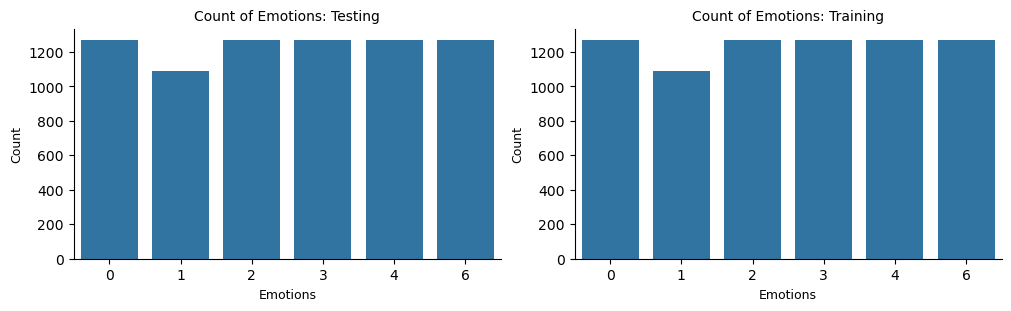

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(10, 3), constrained_layout=True) 

# Plot for Testing Data
axes[0].set_title('Count of Emotions: Testing', size=10)
sns.countplot(x=Crema_df.Emotions, ax=axes[0])
axes[0].set_ylabel('Count', size=9)
axes[0].set_xlabel('Emotions', size=9)
sns.despine(ax=axes[0], top=True, right=True, left=False, bottom=False)

# Plot for Training Data
axes[1].set_title('Count of Emotions: Training', size=10)
sns.countplot(x=Crema_df.Emotions, ax=axes[1])
axes[1].set_ylabel('Count', size=9)
axes[1].set_xlabel('Emotions', size=9)
sns.despine(ax=axes[1], top=True, right=True, left=False, bottom=False)

plt.show()

In [18]:
audio_sample = Crema_df[Crema_df.Emotions == 4].sample(1, random_state=0).iloc[0]
audio_sample

Emotions                                                    4
Path                data/Crema-D/AudioWAV/1073_IEO_DIS_HI.wav
logMel      [[-80.0, -80.0, -58.001003, -30.407433, -30.11...
Name: 6834, dtype: object

In [19]:
Audio(audio_sample['Path'])